In [3]:
# !wget https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py
# !pip install pytorchcv

### Training a dense neural network

In [1]:
!pip install torchinfo

In [2]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary
from pytorchcv import load_mnist, plot_results

load_mnist()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [3]:
net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 10),
    nn.LogSoftmax()
)

In [10]:
print(f'Digit to be predicted: {data_train[0][1]}')

Digit to be predicted: 5


In [11]:
torch.exp(net(data_train[0][0]))

D:\ProgramData\Anaconda3\envs\hoho_gym\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([[0.1188, 0.1011, 0.1106, 0.0907, 0.1079, 0.0941, 0.0810, 0.0945, 0.1114,
         0.0899]], grad_fn=<ExpBackward0>)

In [12]:
train_loader = torch.utils.data.DataLoader(data_train, batch_size=64)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=64)

In [19]:
def train_epoch(net, dataloader, lr=0.01, optimizer=None, loss_fn=nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(), lr=lr)
    net.train()
    total_loss, acc, acount = 0, 0, 0
    count = 0
    for features, labels, in dataloader:
        optimizer.zero_grad()
        out = net(features)
        loss = loss_fn(out, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss
        _, predicted = torch.max(out, 1)
        acc += (predicted==labels).sum()
        count += len(labels)
    return total_loss.item() / count, acc.item() / count

In [20]:
train_epoch(net, train_loader)

(0.0058814814249674476, 0.8941666666666667)

In [22]:
test = torch.tensor([[0.2, 0.8], [0.7, 0.3]])
torch.max(test, 1)

torch.return_types.max(
values=tensor([0.8000, 0.7000]),
indices=tensor([1, 0]))

In [23]:
def validate(net, dataloader,loss_fn=nn.NLLLoss()):
    net.eval()
    count,acc,loss = 0,0,0
    with torch.no_grad():
        for features,labels in dataloader:
            out = net(features)
            loss += loss_fn(out,labels) 
            pred = torch.max(out,1)[1]
            acc += (pred==labels).sum()
            count += len(labels)
    return loss.item()/count, acc.item()/count

validate(net,test_loader)

(0.0058835140228271484, 0.8936)

In [24]:
def train(net,train_loader,test_loader,optimizer=None,lr=0.01,epochs=10,loss_fn=nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for ep in range(epochs):
        tl,ta = train_epoch(net,train_loader,optimizer=optimizer,lr=lr,loss_fn=loss_fn)
        vl,va = validate(net,test_loader,loss_fn=loss_fn)
        print(f"Epoch {ep:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
    return res

In [25]:
net = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(784,10), # 784 inputs, 10 outputs
        nn.LogSoftmax())
hist = train(net,train_loader,test_loader,epochs=5)

Epoch  0, Train acc=0.893, Val acc=0.894, Train loss=0.006, Val loss=0.006
Epoch  1, Train acc=0.910, Val acc=0.899, Train loss=0.005, Val loss=0.006
Epoch  2, Train acc=0.913, Val acc=0.899, Train loss=0.005, Val loss=0.006
Epoch  3, Train acc=0.915, Val acc=0.897, Train loss=0.005, Val loss=0.006
Epoch  4, Train acc=0.916, Val acc=0.897, Train loss=0.005, Val loss=0.006


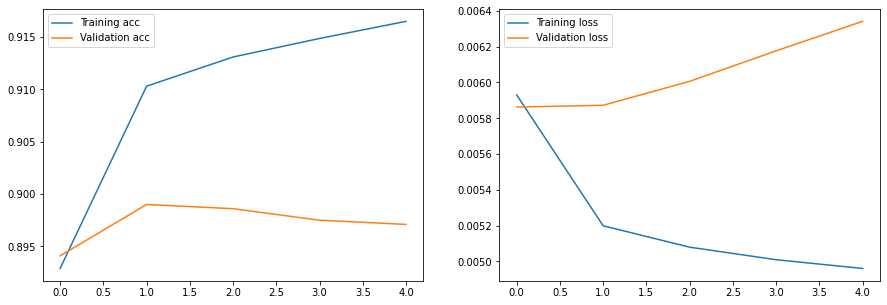

In [26]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(hist['train_acc'], label='Training acc')
plt.plot(hist['val_acc'], label='Validation acc')
plt.legend()
plt.subplot(122)
plt.plot(hist['train_loss'], label='Training loss')
plt.plot(hist['val_loss'], label='Validation loss')
plt.legend()

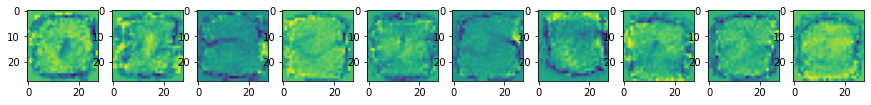

In [28]:
weight_tensor = next(net.parameters())
fig, ax = plt.subplots(1, 10, figsize=(15, 4))
for i, x in enumerate(weight_tensor):
    ax[i].imshow(x.view(28, 28).detach())


In [29]:
net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.LogSoftmax(dim=0)
)

summary(net)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Flatten: 1-1                           --
├─Linear: 1-2                            78,500
├─ReLU: 1-3                              --
├─Linear: 1-4                            1,010
├─LogSoftmax: 1-5                        --
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0

In [30]:
from torch.nn.functional import relu, log_softmax

In [36]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.flatten = nn.Flatten()
        self.hidden = nn.Linear(784, 100)
        self.out = nn.Linear(100, 10)
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.hidden(x)
        x = relu(x)
        x = self.out(x)
        x = log_softmax(x, dim=0)
        return x
    
net = MyNet()

summary(net, input_size=(1, 28, 28), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
MyNet                                    [1, 10]                   --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 100]                  78,500
├─Linear: 1-3                            [1, 10]                   1,010
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
Total mult-adds (M): 0.08
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.32
Estimated Total Size (MB): 0.32

Epoch  0, Train acc=0.927, Val acc=0.941, Train loss=0.035, Val loss=0.034
Epoch  1, Train acc=0.951, Val acc=0.948, Train loss=0.033, Val loss=0.033
Epoch  2, Train acc=0.956, Val acc=0.956, Train loss=0.033, Val loss=0.033
Epoch  3, Train acc=0.959, Val acc=0.951, Train loss=0.033, Val loss=0.033
Epoch  4, Train acc=0.962, Val acc=0.952, Train loss=0.033, Val loss=0.033


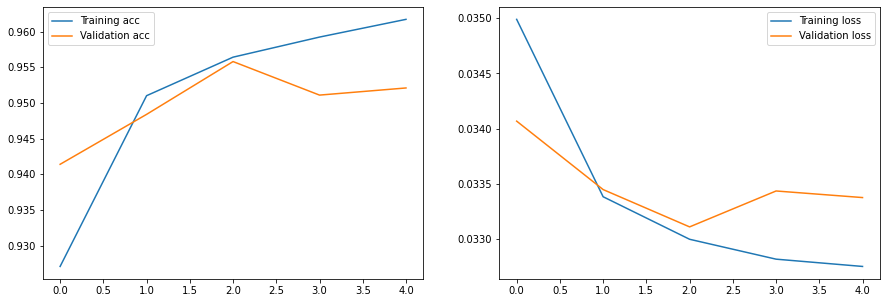

In [37]:
hist = train(net, train_loader, test_loader, epochs=5)
plot_results(hist)

### Convolutional neural networks

In [39]:
import numpy as np
from pytorchcv import *

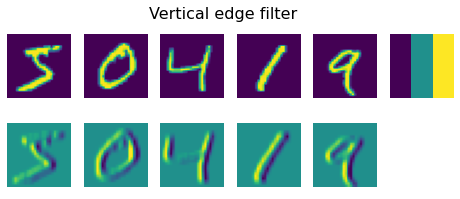

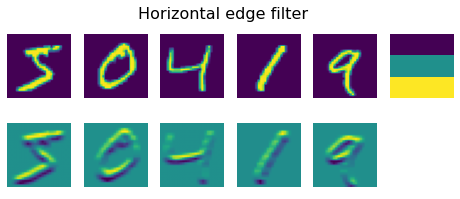

In [40]:
plot_convolution(torch.tensor([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]), 'Vertical edge filter')
plot_convolution(torch.tensor([[-1, -1, -1], [0, 0, 0], [1, 1, 1]]), 'Horizontal edge filter')

In [41]:
class OneConv(nn.Module):
    def __init__(self):
        super(OneConv, self).__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=9, kernel_size=(5, 5))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(5184, 10)
        
    def forward(self, x):
        x = nn.functional.relu(self.conv(x))
        x = self.flatten(x)
        x = nn.functional.log_softmax(self.fc(x), dim=1)
        
        return x
    
    

In [44]:
net = OneConv().to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
summary(net)

Layer (type:depth-idx)                   Param #
OneConv                                  --
├─Conv2d: 1-1                            234
├─Flatten: 1-2                           --
├─Linear: 1-3                            51,850
Total params: 52,084
Trainable params: 52,084
Non-trainable params: 0

Epoch  0, Train acc=0.954, Val acc=0.970, Train loss=0.002, Val loss=0.001
Epoch  1, Train acc=0.977, Val acc=0.977, Train loss=0.001, Val loss=0.001
Epoch  2, Train acc=0.982, Val acc=0.974, Train loss=0.001, Val loss=0.002
Epoch  3, Train acc=0.986, Val acc=0.977, Train loss=0.001, Val loss=0.002
Epoch  4, Train acc=0.988, Val acc=0.967, Train loss=0.001, Val loss=0.003


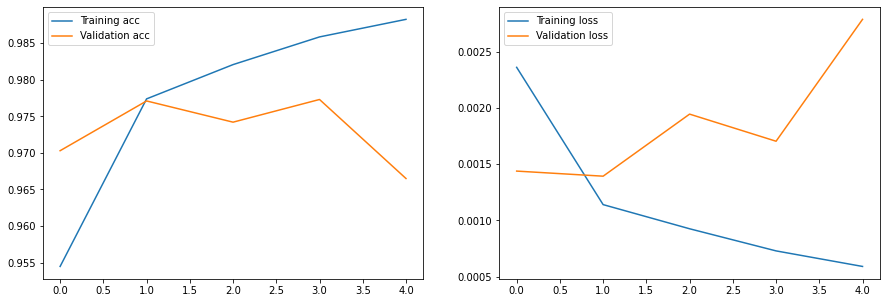

In [45]:
hist = train(net, train_loader, test_loader, epochs=5)
plot_results(hist)

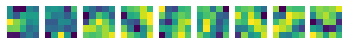

In [46]:
fig,ax = plt.subplots(1,9)
with torch.no_grad():
    p = next(net.conv.parameters())
    for i,x in enumerate(p):
        ax[i].imshow(x.detach().cpu()[0,...])
        ax[i].axis('off')

### Multi-Layered CNNs

In [50]:
class MultiLayerCNN(nn.Module):
    def __init__(self):
        super(MultiLayerCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.fc = nn.Linear(320,10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 320)
        x = nn.functional.log_softmax(self.fc(x),dim=1)
        return x

net = MultiLayerCNN()
summary(net,input_size=(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
MultiLayerCNN                            [1, 10]                   --
├─Conv2d: 1-1                            [1, 10, 24, 24]           260
├─MaxPool2d: 1-2                         [1, 10, 12, 12]           --
├─Conv2d: 1-3                            [1, 20, 8, 8]             5,020
├─MaxPool2d: 1-4                         [1, 20, 4, 4]             --
├─Linear: 1-5                            [1, 10]                   3,210
Total params: 8,490
Trainable params: 8,490
Non-trainable params: 0
Total mult-adds (M): 0.47
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.03
Estimated Total Size (MB): 0.09

In [51]:
hist = train(net,train_loader,test_loader,epochs=5)

Epoch  0, Train acc=0.958, Val acc=0.960, Train loss=0.002, Val loss=0.002
Epoch  1, Train acc=0.980, Val acc=0.978, Train loss=0.001, Val loss=0.001
Epoch  2, Train acc=0.982, Val acc=0.977, Train loss=0.001, Val loss=0.001
Epoch  3, Train acc=0.982, Val acc=0.984, Train loss=0.001, Val loss=0.001
Epoch  4, Train acc=0.983, Val acc=0.978, Train loss=0.001, Val loss=0.001


In [57]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context   # 必须加上这个，不然下面不能下载数据集

In [62]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=14, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(trainset, batch_size=14, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


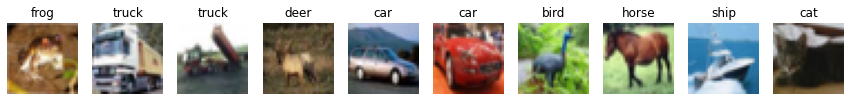

In [63]:
display_dataset(trainset,classes=classes)

In [64]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16,120,5)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(120,64)
        self.fc2 = nn.Linear(64,10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = nn.functional.relu(self.conv3(x))
        x = self.flat(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = LeNet().to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

summary(net,input_size=(1,3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 28, 28]            456
├─MaxPool2d: 1-2                         [1, 6, 14, 14]            --
├─Conv2d: 1-3                            [1, 16, 10, 10]           2,416
├─MaxPool2d: 1-4                         [1, 16, 5, 5]             --
├─Conv2d: 1-5                            [1, 120, 1, 1]            48,120
├─Flatten: 1-6                           [1, 120]                  --
├─Linear: 1-7                            [1, 64]                   7,744
├─Linear: 1-8                            [1, 10]                   650
Total params: 59,386
Trainable params: 59,386
Non-trainable params: 0
Total mult-adds (M): 0.66
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.30

In [65]:
opt = torch.optim.SGD(net.parameters(), lr=2e-5, momentum=0.9)
hist = train(net, trainloader, testloader, epochs=3, optimizer=opt, loss_fn=nn.CrossEntropyLoss())

Epoch  0, Train acc=0.101, Val acc=0.101, Train loss=0.165, Val loss=0.165
Epoch  1, Train acc=0.101, Val acc=0.101, Train loss=0.165, Val loss=0.165
Epoch  2, Train acc=0.101, Val acc=0.101, Train loss=0.164, Val loss=0.164


### Pre-trained models and transfer learning

In [71]:
import os
import torchvision.transforms as transforms

In [68]:
# if not os.path.exists('data/kagglecatsanddogs_3367a.zip'):
#     !wget -P data -q https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

'wget' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


In [ ]:
# import zipfile
# if not os.path.exists('data/PetImages'):
#     with zipfile.ZipFile('data/kagglecatsanddogs_3367a.zip', 'r') as zip_ref:
#         zip_ref.extractall('data')

In [75]:
check_image_dir('data/dogs-vs-cats/PetImages/Cat/*.jpg')
check_image_dir('data/dogs-vs-cats/PetImages/Dog/*.jpg')

In [76]:
std_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
trans = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    std_normalize
    
])

dataset = torchvision.datasets.ImageFolder('data/dogs-vs-cats/PetImages', transform=trans)
trainset, testset = torch.utils.data.random_split(dataset, [20000, len(dataset) - 20000])

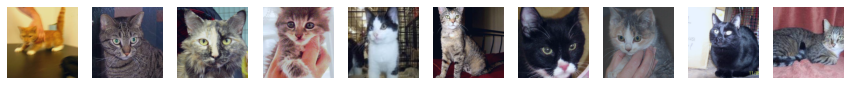

In [77]:
display_dataset(dataset)

In [78]:
vgg = torchvision.models.vgg16(pretrained=True)
sample_image = dataset[0][0].unsqueeze(0)
res = vgg(sample_image)
print(res[0].argmax())

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\Administrator/.cache\torch\hub\checkpoints\vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

tensor(281)


In [91]:
import json, requests

with open('imagenet1000_clsidx_to_labels.json', 'r') as file_r:
    class_map = json.load(file_r)
    class_map = {int(k): v for k, v in class_map.items()}
    

In [93]:
class_map[res[0].argmax().item()]

'tabby, tabby cat'

In [95]:
summary(vgg, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 1000]                 --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        147,584
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]          29

In [97]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg.to(device)
sample_image = sample_image.to(device)
vgg(sample_image).argmax()

tensor(282, device='cuda:0')

torch.Size([1, 512, 7, 7])


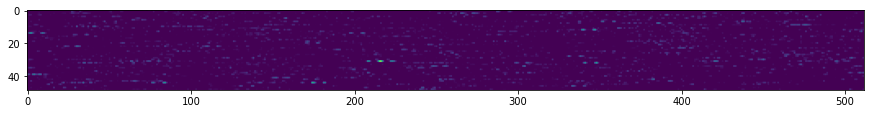

In [98]:
res = vgg.features(sample_image).cpu()
plt.figure(figsize=(15, 3))
plt.imshow(res.detach().view(-1, 512))
print(res.size())

In [100]:
bs = 8
dl = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)
num = bs * 100
feature_tensor = torch.zeros(num, 512 * 7 * 7).to(device)
label_tensor = torch.zeros(num).to(device)
i = 0
for x, l in dl:
    with torch.no_grad():
        f = vgg.features(x.to(device))
        feature_tensor[i:i+bs] = f.view(bs, -1)
        label_tensor[i:i+bs] = l
        i += bs
        print('.', end='')
        if i >= num:
            break

....................................................................................................

In [101]:
vgg_dataset = torch.utils.data.TensorDataset(feature_tensor,label_tensor.to(torch.long))
train_ds, test_ds = torch.utils.data.random_split(vgg_dataset,[700,100])

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=32)

net = torch.nn.Sequential(torch.nn.Linear(512*7*7,2),torch.nn.LogSoftmax()).to(device)

history = train(net,train_loader,test_loader)

Epoch  0, Train acc=0.909, Val acc=0.940, Train loss=0.058, Val loss=0.095
Epoch  1, Train acc=0.987, Val acc=0.920, Train loss=0.006, Val loss=0.126
Epoch  2, Train acc=0.987, Val acc=0.930, Train loss=0.011, Val loss=0.128
Epoch  3, Train acc=0.996, Val acc=0.950, Train loss=0.009, Val loss=0.073
Epoch  4, Train acc=1.000, Val acc=0.960, Train loss=0.000, Val loss=0.084
Epoch  5, Train acc=1.000, Val acc=0.960, Train loss=0.000, Val loss=0.085
Epoch  6, Train acc=1.000, Val acc=0.960, Train loss=0.000, Val loss=0.086
Epoch  7, Train acc=1.000, Val acc=0.960, Train loss=0.000, Val loss=0.086
Epoch  8, Train acc=1.000, Val acc=0.960, Train loss=0.000, Val loss=0.086
Epoch  9, Train acc=1.000, Val acc=0.960, Train loss=0.000, Val loss=0.086


In [102]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [104]:
vgg.classifier = torch.nn.Linear(25088, 2).to(device)  # 最后分类层重新定义
for x in vgg.features.parameters():
    x.requires_grad = False   # freeze vgg的卷积层
    
summary(vgg, (1, 3, 244, 244))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 2]                    --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 244, 244]         (1,792)
│    └─ReLU: 2-2                         [1, 64, 244, 244]         --
│    └─Conv2d: 2-3                       [1, 64, 244, 244]         (36,928)
│    └─ReLU: 2-4                         [1, 64, 244, 244]         --
│    └─MaxPool2d: 2-5                    [1, 64, 122, 122]         --
│    └─Conv2d: 2-6                       [1, 128, 122, 122]        (73,856)
│    └─ReLU: 2-7                         [1, 128, 122, 122]        --
│    └─Conv2d: 2-8                       [1, 128, 122, 122]        (147,584)
│    └─ReLU: 2-9                         [1, 128, 122, 122]        --
│    └─MaxPool2d: 2-10                   [1, 128, 61, 61]          --
│    └─Conv2d: 2-11                      [1, 256, 61, 61]    

In [105]:
trainset, testset = torch.utils.data.random_split(dataset,[20000,len(dataset)-20000])
train_loader = torch.utils.data.DataLoader(trainset,batch_size=16)
test_loader = torch.utils.data.DataLoader(testset,batch_size=16)

train_long(vgg,train_loader,test_loader,loss_fn=torch.nn.CrossEntropyLoss(),epochs=1,print_freq=90)

Epoch 0, minibatch 0: train acc = 0.375, train loss = 0.048850592225790024
Epoch 0, minibatch 90: train acc = 0.9306318681318682, train loss = 0.24092898526034512
Epoch 0, minibatch 180: train acc = 0.9488950276243094, train loss = 0.17658187276092024
Epoch 0, minibatch 270: train acc = 0.955950184501845, train loss = 0.15566553488868629
Epoch 0, minibatch 360: train acc = 0.961218836565097, train loss = 0.13886390960777895
Epoch 0, minibatch 450: train acc = 0.9636917960088692, train loss = 0.13194578555629416
Epoch 0, minibatch 540: train acc = 0.9654574861367837, train loss = 0.1339321594802377
Epoch 0, minibatch 630: train acc = 0.9650356576862124, train loss = 0.15646930579715976
Epoch 0, minibatch 720: train acc = 0.9662794729542302, train loss = 0.1570116802326684
Epoch 0, minibatch 810: train acc = 0.9680178791615289, train loss = 0.15232633691827702
Epoch 0, minibatch 900: train acc = 0.969062153163152, train loss = 0.15045077951581576
Epoch 0, minibatch 990: train acc = 0.969

In [106]:
torch.save(vgg, './cats_dogs.pth')

In [107]:
vgg = torch.load('./cats_dogs.pth')

### Lightweight networks and MobileNet

In [118]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)
model.eval()
print(model)

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

Using cache found in C:\Users\Administrator/.cache\torch\hub\pytorch_vision_v0.6.0


In [114]:
# summary(model, (1, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
MobileNetV2                                   [1, 1000]                 --
├─Sequential: 1-1                             [1, 1280, 7, 7]           --
│    └─ConvNormActivation: 2-1                [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                       [1, 32, 112, 112]         864
│    │    └─BatchNorm2d: 3-2                  [1, 32, 112, 112]         64
│    │    └─ReLU6: 3-3                        [1, 32, 112, 112]         --
│    └─InvertedResidual: 2-2                  [1, 16, 112, 112]         --
│    │    └─Sequential: 3-4                   [1, 16, 112, 112]         896
│    └─InvertedResidual: 2-3                  [1, 24, 56, 56]           --
│    │    └─Sequential: 3-5                   [1, 24, 56, 56]           5,136
│    └─InvertedResidual: 2-4                  [1, 24, 56, 56]           --
│    │    └─Sequential: 3-6                   [1, 24, 56, 56]           8,832
│    └─Inver

In [121]:
sample_image = dataset[0][0].unsqueeze(0)
res = model(sample_image)
print(res[0].argmax().item())
print(class_map[res[0].argmax().item()])

903
wig


In [113]:
sample_image.size()

torch.Size([1, 3, 224, 224])

In [122]:
for x in model.parameters():
    x.requires_grad = False

In [131]:
model.classifier = nn.Linear(1280, 2)
model.to(device)
summary(model, input_size=(1, 3, 244, 244))

Layer (type:depth-idx)                        Output Shape              Param #
MobileNetV2                                   [1, 2]                    --
├─Sequential: 1-1                             [1, 1280, 8, 8]           --
│    └─ConvNormActivation: 2-1                [1, 32, 122, 122]         --
│    │    └─Conv2d: 3-1                       [1, 32, 122, 122]         (864)
│    │    └─BatchNorm2d: 3-2                  [1, 32, 122, 122]         (64)
│    │    └─ReLU6: 3-3                        [1, 32, 122, 122]         --
│    └─InvertedResidual: 2-2                  [1, 16, 122, 122]         --
│    │    └─Sequential: 3-4                   [1, 16, 122, 122]         (896)
│    └─InvertedResidual: 2-3                  [1, 24, 61, 61]           --
│    │    └─Sequential: 3-5                   [1, 24, 61, 61]           (5,136)
│    └─InvertedResidual: 2-4                  [1, 24, 61, 61]           --
│    │    └─Sequential: 3-6                   [1, 24, 61, 61]           (8,832)
│ 

In [ ]:
train_long(model,train_loader,test_loader,loss_fn=torch.nn.CrossEntropyLoss(),epochs=1,print_freq=90)

Epoch 0, minibatch 0: train acc = 0.5625, train loss = 0.04977239668369293
Epoch 0, minibatch 90: train acc = 0.8983516483516484, train loss = 0.02304970825111473
Epoch 0, minibatch 180: train acc = 0.9150552486187845, train loss = 0.020427345570938362
Epoch 0, minibatch 270: train acc = 0.9213560885608856, train loss = 0.019616295930644245
Epoch 0, minibatch 360: train acc = 0.9291897506925207, train loss = 0.017432414924008693
Epoch 0, minibatch 450: train acc = 0.9309866962305987, train loss = 0.017224620556884226
Epoch 0, minibatch 540: train acc = 0.9311460258780037, train loss = 0.01776087262053146
Epoch 0, minibatch 630: train acc = 0.9323494453248812, train loss = 0.017759923133910553
Epoch 0, minibatch 720: train acc = 0.9312586685159501, train loss = 0.019042144701318833
Epoch 0, minibatch 810: train acc = 0.9326448828606658, train loss = 0.01929480344534802
Epoch 0, minibatch 900: train acc = 0.9331992230854605, train loss = 0.019948872556696987
